In [24]:
cd /Users/amandaash/Desktop/Research/scripts/

/Users/amandaash/Desktop/Research/scripts


In [25]:
from __future__ import print_function, division, absolute_import

import os

%matplotlib inline
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.io.ascii as at
import astropy.io.fits as fits
import astropy.units as u
from scipy.interpolate import interp1d
from cycler import cycler
import glob as glob
import spectra_functions
import pyspeckit
from PHEW import EqW as eqw
import pyspeckit as p
from scipy import stats
import csv
import statistics
import matplotlib.colors as colors
from datetime import date

In [26]:
def findMiddle(input_list):
    middle = (len(input_list))/2
    if str(middle)[-1] == '0':
        return [input_list[int(middle)], input_list[int(middle-1)]]
    elif str(middle)[-1] == '5':
        return [input_list[int(middle - .5)]]

EPIC211928486 2017-11-28


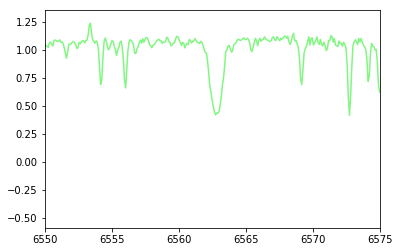

In [27]:
fname = '/Users/amandaash/Desktop/Research/data/Morris_targets/211928486/stack_EPIC211928486_2017-11-28.txt'
dat = np.genfromtxt(fname)
wave = dat[:,0]
flux = dat[:,1]
name = fname.split('/')[-1].split('_')[1]
UTC_date = fname.split('/')[-1].split('_')[-1].split('.')[0]

print(name, UTC_date)

plt.plot(wave,flux)
plt.xlim(6550,6575)
plt.show()

f_211928486 = sorted(glob.glob('/Users/amandaash/Desktop/Research/data/Morris_targets/211928486/*.txt'))
for fname in f_211928486:
    name = 'EPIC 211928486'
    date = (fname.split('/')[8]).split('_')[2].split('.')[0]
    eperc = eqw.measure_equivalent_width_txt(str(fname),
                                     6560,6568,6561,6566,
                                     1000,xunit="Angstrom",to_plot=True,
                                     filebase="/Users/amandaash/Desktop/Research/plots/figures_morris/{0}_{1}.pdf".format(name,date))

f_211966629 = sorted(glob.glob('/Users/amandaash/Desktop/Research/data/Morris_targets/211966629/*.txt'))
for fname in f_211966629:
    name = 'EPIC 211966629'
    date = (fname.split('/')[8]).split('_')[2].split('.')[0]
    eperc = eqw.measure_equivalent_width_txt(str(fname),
                                     6560,6568,6561,6566,
                                     1000,xunit="Angstrom",to_plot=True,
                                     filebase="/Users/amandaash/Desktop/Research/plots/figures_morris/{0}_{1}.pdf".format(name,date))

In [28]:
today = date.today().isoformat()

obs_info = []
with open('/Users/amandaash/Desktop/Research/target_info/obs_table_715_update.csv', 'r') as csvFile:
    obs_data = csv.reader(csvFile)
    for row in obs_data:
    
        obs_info.append(list(row))
csvFile.close()

morris_info = []
with open('/Users/amandaash/Desktop/Research/target_info/morris_obs_tab.csv', 'r') as csvFile:
    obs_data = csv.reader(csvFile)
    for row in obs_data:
        morris_info.append(list(row))
csvFile.close()

targets = []

for row in obs_info[1:]:
    targets.append(row[0])
for row in morris_info:
    targets.append(row[0])

    
unique_target = sorted(list(set(targets)))


with open('/Users/amandaash/Desktop/Research/analysis/tables/correlation_{0}.csv'.format(today),'w') as csvFile:
    row1 = ['litname', 'EPIC ID', 'spec type', 'P_rot', 'm_flux', 'r_flux', 'p_flux', 'std_flux', 'C_1', 'V_1', 
            'V_2', 'sigma V_2', 'R_EW', 'R_EW_error', 'med_EW', 'std_EW']
    wr = csv.writer(csvFile, dialect = 'excel')
    wr.writerow(row1)
csvFile.close()

for target in unique_target:
    EqW_array = []
    lower_error_array = []
    upper_error_array = []
    JD = []
    for n in obs_info[1:]:
        
        name = n[0]
        
        if name == target and n[13] == '0':
            
            UTC_date = n[5]
            UTC_time = n[6]       
            UTC = str(UTC_date)  + ' ' + str(UTC_time)     
            UTC_time= Time(UTC, scale = 'utc')
    
            JD_time = UTC_time.jd
            JD.append(float(JD_time))
            
            EqW = float(n[11])
            perc16 = float(n[10])
            perc84 = float(n[12])
            lower_uncertainty = EqW - perc16
            lower_error_array.append(lower_uncertainty)
            upper_uncertainty = perc84 - EqW
            upper_error_array.append(upper_uncertainty)
            EqW_array.append(EqW)
    
        
        else:
            continue
    
    for n in morris_info[1:]:
        
        name = n[0]
        
        if name == target:
        
            JD_time = n[4]
            JD.append(float(JD_time))
            
            EqW = float(n[6])
            perc16 = float(n[5])
            perc84 = float(n[7])
            lower_uncertainty = EqW - perc16
            lower_error_array.append(lower_uncertainty)
            upper_uncertainty = perc84 - EqW
            upper_error_array.append(upper_uncertainty)
            EqW_array.append(EqW)
    
    if len(EqW_array) <= 2:
        continue
    
    plt.figure(figsize=(16,14))
    ax = plt.subplot(111)
    v = [lower_error_array, upper_error_array]
    days = np.arange(20180110,20180131,1)
    np.append(days, np.arange(20180200,20180209,1))
    #print(v.shape)
    ax.errorbar(JD,EqW_array, yerr = v, fmt = 'o', color = 'b')
    #ax.plot(date_array,EqW_array, linestyle = 'dotted')
    ax.set_ylim(np.max(EqW_array) + 3*np.std(EqW_array), np.min(EqW_array)-3*np.std(EqW_array))
    ax.set_title(target, fontsize = 30)
    ax.set_ylabel(r'$H_{\alpha}\ EW\ (\AA)$', fontsize = 26, labelpad = 24)
    ax.set_xlabel('time (days)', fontsize = 26, labelpad = 24)
    ax.tick_params(labelsize = 24)
    #plt.savefig('/Users/amandaash/Desktop/Research/plots/EW_variability_62319/{0}_EW_variability.pdf'.format(target))
    plt.tight_layout()
    plt.close()
    
    std_points = np.std(EqW_array)

    avg_errorbar_squared = []
    
    v_err = np.column_stack((lower_error_array, upper_error_array))
    
    for bar in v_err:
        avg_sigma = (np.abs(bar[0]) + np.abs(bar[1]))/2
        avg_sigma_squared = avg_sigma**2
        avg_errorbar_squared.append(avg_sigma_squared)
    
    avg_sig_square = np.mean(avg_errorbar_squared)
    
    rms_sigma = np.sqrt(avg_sig_square)

    vary_stat = std_points/rms_sigma
    
    
    max_EW = np.max(EqW_array)
    min_EW = np.min(EqW_array)
    med_EW1 = np.median(EqW_array)
    med_EW2 = statistics.median(EqW_array)
    
    max_EW_index = np.where(EqW_array == max_EW)
    min_EW_index = np.where(EqW_array == min_EW)
    max_sigma = (np.abs(v[0][max_EW_index[0][0]])) + (np.abs(v[1][max_EW_index[0][0]]))/2
    min_sigma = (np.abs(v[0][min_EW_index[0][0]])) + (np.abs(v[1][min_EW_index[0][0]]))/2 
    
    top = max_EW - min_EW
    top_sigma = np.sqrt(max_sigma**2 + min_sigma**2)
    
    R_EW = max_EW/min_EW
    
    R_EW_error = R_EW*np.sqrt(((max_sigma/max_EW)**2)+(min_sigma/min_EW)**2)
    
    stats_info = []

    with open('/Users/amandaash/Desktop/Research/analysis/tables/correlation_lightcurve_{0}.csv'.format(today),'r') as csvFile:
        stats = csv.reader(csvFile)
        for row in stats:
            stats_info.append(row)

    
    for n in stats_info[1:]:

        if n[0] == target:
            with open('/Users/amandaash/Desktop/Research/analysis/tables/correlation_{0}.csv'.format(today),'a') as csvFile:
                row = [n[0], n[1], n[2], n[3], n[4], n[5], n[6], n[7], n[8], vary_stat, top, top_sigma, R_EW, R_EW_error, med_EW1, std_points]
                wr = csv.writer(csvFile, dialect = 'excel')
                wr.writerow(row)
            csvFile.close()


In [29]:
from scipy import stats
obs_info = []
with open('/Users/amandaash/Desktop/Research/target_info/obs_table_715_update.csv', 'r') as csvFile:
    obs_data = csv.reader(csvFile)
    for row in obs_data:
    
        obs_info.append(list(row))
csvFile.close()

targets = []

for row in obs_info[1:]:
    targets.append(row[0])


with open('/Users/amandaash/Desktop/Research/analysis/tables/correlation_secz_OSMOS_{0}.csv'.format(today),'w') as csvFile:
    row1 = ['litname', 'EPIC ID', 'spec type', 'P_rot', 'm_flux', 'r_flux', 'p_flux', 'std_flux', 'C_flux', 'V_1', 
            'V_2', 'sigma V_2', 'R_EW', 'R_EW_error', 'med_EW', 'std_EW', 'm_secz', 'r_secz', 'p_secz',
            'std_secz', 'C_secz']
    wr = csv.writer(csvFile, dialect = 'excel')
    wr.writerow(row1)
csvFile.close()

corr_info = []

with open('/Users/amandaash/Desktop/Research/analysis/tables/correlation_{0}.csv'.format(today), 'r') as csvFile:
    corr_data = csv.reader(csvFile)
    for corr in corr_data:
        if corr[0] == 'JS482':
            continue
        if corr[0] == 'JS556':
            continue
        else:
            corr_info.append(corr)

    
unique_target = sorted(list(set(targets)))

for n in unique_target:
    secz_good = []
    EW_good = []
    EW_ue_good = []
    EW_le_good = []
    
    secz_bad = []
    EW_bad = []
    EW_ue_bad = []
    EW_le_bad = []
    
    for row in obs_info[1:]:
        target_name = row[0]
        quality_flag = row[13]
        EPIC = row[1]
        if target_name == n and quality_flag == '0':
            sec = float(row[8])
            EqW = float(row[11])
            perc16 = float(row[10])
            perc84 = float(row[12])
            lower_uncertainty = EqW - perc16
            secz_good.append(sec)
            EW_le_good.append(lower_uncertainty)
            upper_uncertainty = perc84 - EqW
            EW_ue_good.append(upper_uncertainty)
            EW_good.append(EqW)
        if target_name == n and quality_flag == '2':
            sec = float(row[8])
            EqW = float(row[11])
            perc16 = float(row[10])
            perc84 = float(row[12])
            lower_uncertainty = EqW - perc16
            secz_bad.append(sec)
            EW_le_bad.append(lower_uncertainty)
            upper_uncertainty = perc84 - EqW
            EW_ue_bad.append(upper_uncertainty)
            EW_bad.append(EqW)
        

    if len(list(EW_good)) <= 2:
        continue
        
    slope, intercept, rvalue, pvalue, std_err = stats.linregress(secz_good, EW_good)
    line = slope*np.array(secz_good) + intercept
    
    plt.figure(figsize=(16,14))    
    v_err_good = [EW_le_good, EW_ue_good]
    v_err_bad = [EW_le_bad, EW_ue_bad]
    plt.errorbar(secz_good, EW_good, yerr = v_err_good, fmt = 'o')
    plt.errorbar(secz_bad, EW_bad, yerr = v_err_bad, fmt = 'o', color = 'r')
    plt.plot(secz_good, line, color = 'k', linestyle = 'dashed')
    plt.ylim(np.max(EW_good) + 3*np.std(EW_good), np.min(EW_good)-3*np.std(EW_good))
    plt.text(np.min(secz_good) + 0.01, np.max(EW_good) + np.std(EW_good),r'$m = $' + '%s' % float('%.6g' % slope), fontsize = 30)
    plt.text(np.min(secz_good) + 0.01, np.max(EW_good) + 2*np.std(EW_good),r'$\sigma = $' + '%s' % float('%.6g' % std_err), fontsize = 30)
    plt.title(n, fontsize = 30)
    plt.ylabel(r'$H_{\alpha}\ EW\ (\AA)$', fontsize = 26, labelpad = 24)
    plt.xlabel('sec(z)', fontsize = 26, labelpad = 24)
    plt.tick_params(labelsize = 24)
    plt.tight_layout()
    #plt.savefig('/Users/amandaash/Desktop/Research/plots/obs_analysis/secz/{0}.pdf'.format(n))
    plt.close()
    
    
    for row in corr_info[1:]:
        
        target_name = row[0]
        if target_name == n:
            
            EPIC = row[1]
            spec_type = row[2]
            P_rot = row[3]
            m1 = row[4]
            r1 = row[5]
            p1 = row[6]
            std1 = row[7]
            mstd1 = float(row[8])
            std_rms = row[9]
            v2 = row[10]
            v2_err = row[11]
            R_EW = row[12]
            R_EW_sigma = row[13]
            med_EW = row[14]
            std_EW = row[15]
            m2 = slope
            r2 = rvalue
            p2 = pvalue
            std2 = std_err
            mstd2 = slope/std_err
            
            corr_row = [target_name, EPIC, spec_type, P_rot, m1, r1, p1, std1, mstd1, std_rms, v2, v2_err, R_EW, R_EW_sigma, med_EW, std_EW, m2, r2, p2, std2, mstd2]
            
            with open('/Users/amandaash/Desktop/Research/analysis/tables/correlation_secz_OSMOS_{0}.csv'.format(today),'a') as csvFile:
                wr = csv.writer(csvFile, dialect = 'excel')
                wr.writerow(corr_row)
            csvFile.close()
            

In [30]:
obs_info = []
with open('/Users/amandaash/Desktop/Research/target_info/obs_table_715_update.csv', 'r') as csvFile:
    obs_data = csv.reader(csvFile)
    for row in obs_data:
    
        obs_info.append(list(row))
csvFile.close()

targets = []

for row in obs_info[1:]:
    targets.append(row[0])

    
unique_target = sorted(list(set(targets)))

for target in unique_target:
    OI_shift_good = []
    EW_good = []
    EW_ue_good = []
    EW_le_good = []
    
    OI_shift_bad = []
    EW_bad = []
    EW_ue_bad = []
    EW_le_bad = []
    
    for row in obs_info[1:]:
        target_name = row[0]
        quality_flag = row[13]
        if target_name == target and quality_flag == '0':
            OI = float(row[9])
            EqW = float(row[11])
            perc16 = float(row[10])
            perc84 = float(row[12])
            lower_uncertainty = EqW - perc16
            OI_shift_good.append([OI])
            EW_le_good.append(lower_uncertainty)
            upper_uncertainty = perc84 - EqW
            EW_ue_good.append(upper_uncertainty)
            EW_good.append(EqW)
        if target_name == target and quality_flag == '2':
            OI = float(row[9])
            EqW = float(row[11])
            perc16 = float(row[10])
            perc84 = float(row[12])
            lower_uncertainty = EqW - perc16
            OI_shift_bad.append(OI)
            EW_le_bad.append(lower_uncertainty)
            upper_uncertainty = perc84 - EqW
            EW_ue_bad.append(upper_uncertainty)
            EW_bad.append(EqW)

    if len(list(EW_good)) <= 2:
        continue
    
    plt.figure(figsize=(16,14))    
    v_err_good = [EW_le_good, EW_ue_good]    
    v_err_bad = [EW_le_bad, EW_ue_bad]
    plt.errorbar(OI_shift_good, EW_good, yerr = v_err_good, fmt = 'o')
    plt.errorbar(OI_shift_bad, EW_bad, yerr = v_err_bad, fmt = 'o', color = '#29088A')
    plt.ylim(np.max(EW_good) + 3*np.std(EW_good), np.min(EW_good)-3*np.std(EW_good))
    plt.title(target, fontsize = 30)
    plt.ylabel(r'$H_{\alpha}\ EW\ (\AA)$', fontsize = 26, labelpad = 24)
    plt.xlabel(r'OI shift', fontsize = 26, labelpad = 24)
    plt.tick_params(labelsize = 24)
    plt.tight_layout()
    plt.savefig('/Users/amandaash/Desktop/Research/plots/obs_analysis/OI_shift/{0}.pdf'.format(target))
    plt.close()
    
    

In [31]:
#OI with dates labled 
obs_info = []
with open('/Users/amandaash/Desktop/Research/target_info/obs_table_715_update.csv', 'r') as csvFile:
    obs_data = csv.reader(csvFile)
    for row in obs_data:
    
        obs_info.append(list(row))
csvFile.close()

targets = []

for row in obs_info[1:]:
    targets.append(row[0])

    
unique_target = sorted(list(set(targets)))

for target in unique_target:
    OI_shift = []
    EW = []
    EW_ue = []
    EW_le = []
    date = []
    flag = []
    
    
    for row in obs_info[1:]:
        target_name = row[0]
        quality_flag = row[13]
        if target_name == target:
            local_date = row[4]
            OI = float(row[9])
            EqW = float(row[11])
            perc16 = float(row[10])
            perc84 = float(row[12])
            lower_uncertainty = EqW - perc16
            OI_shift.append([OI])
            EW_le.append(lower_uncertainty)
            upper_uncertainty = perc84 - EqW
            EW_ue.append(upper_uncertainty)
            EW.append(EqW)
            date.append(local_date)
            flag.append(quality_flag)
    
    if len(list(EW)) <= 2:
        continue
    custom_cycler = (cycler(color=['#81F781', '#01DF3A', '#298A08', '#A9F5D0', '#013ADF', '#D0A9F5', '#00BFFF', 
                                  '#120A2A', '#0489B1', '#DF01D7', '#A901DB', '#8A084B', '#088A4B', '#64FE2E', 
                                  '#F6CEEC', '#0A2A12', '#8000FF', '#F5DA81', '#F78181', '#A9A9F5', '#CEE3F6', 
                                  '#01A9DB', '#8258FA', '#D8D8D8', '#A4A4A4', '#6E6E6E', '#2E2E2E', '#2E2E2E', 
                                  '#9AFE2E', '#0B3B2E', '#071019', '#0B0B3B', '#F8E0E6', '#3A01DF', '#1B2A0A', 
                                   '#DBA901', '#4000FF']))
    plt.figure(figsize=(16,14))
    plt.rc('axes', prop_cycle=custom_cycler)
    data = np.column_stack((OI_shift, EW, EW_le, EW_ue, date, flag))
    for data_pt in data:
        if data_pt[5] == '0':
            plt.errorbar(float(data_pt[0]), float(data_pt[1]), yerr = [[float(data_pt[2])], [float(data_pt[3])]], label = data_pt[4] + ': good', fmt = 'o')
            plt.text(float(data_pt[0]), float(data_pt[1]),data_pt[4],  size = 'small')
        if data_pt[5] == '2':
            plt.errorbar(float(data_pt[0]), float(data_pt[1]), yerr = [[float(data_pt[2])], [float(data_pt[3])]], label = data_pt[4] + ': bad', fmt = 'o')
            plt.text(float(data_pt[0]), float(data_pt[1]),data_pt[4],  size = 'small')
    plt.ylim(np.max(EW) + 3*np.std(EW), np.min(EW)-3*np.std(EW))
    plt.title(target, fontsize = 30)
    plt.ylabel(r'$H_{\alpha}\ EW\ (\AA)$', fontsize = 26, labelpad = 24)
    plt.xlabel(r'OI shift', fontsize = 26, labelpad = 24)
    plt.tick_params(labelsize = 24)
    plt.vlines([3, -3], np.max(EW) + 3*np.std(EW), np.min(EW)-3*np.std(EW), linestyle = 'dashed')
    plt.legend()
    plt.tight_layout()
    plt.savefig('/Users/amandaash/Desktop/Research/plots/obs_analysis/OI_shift_labeled/{0}.pdf'.format(target))
    plt.close()
    
    

In [32]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

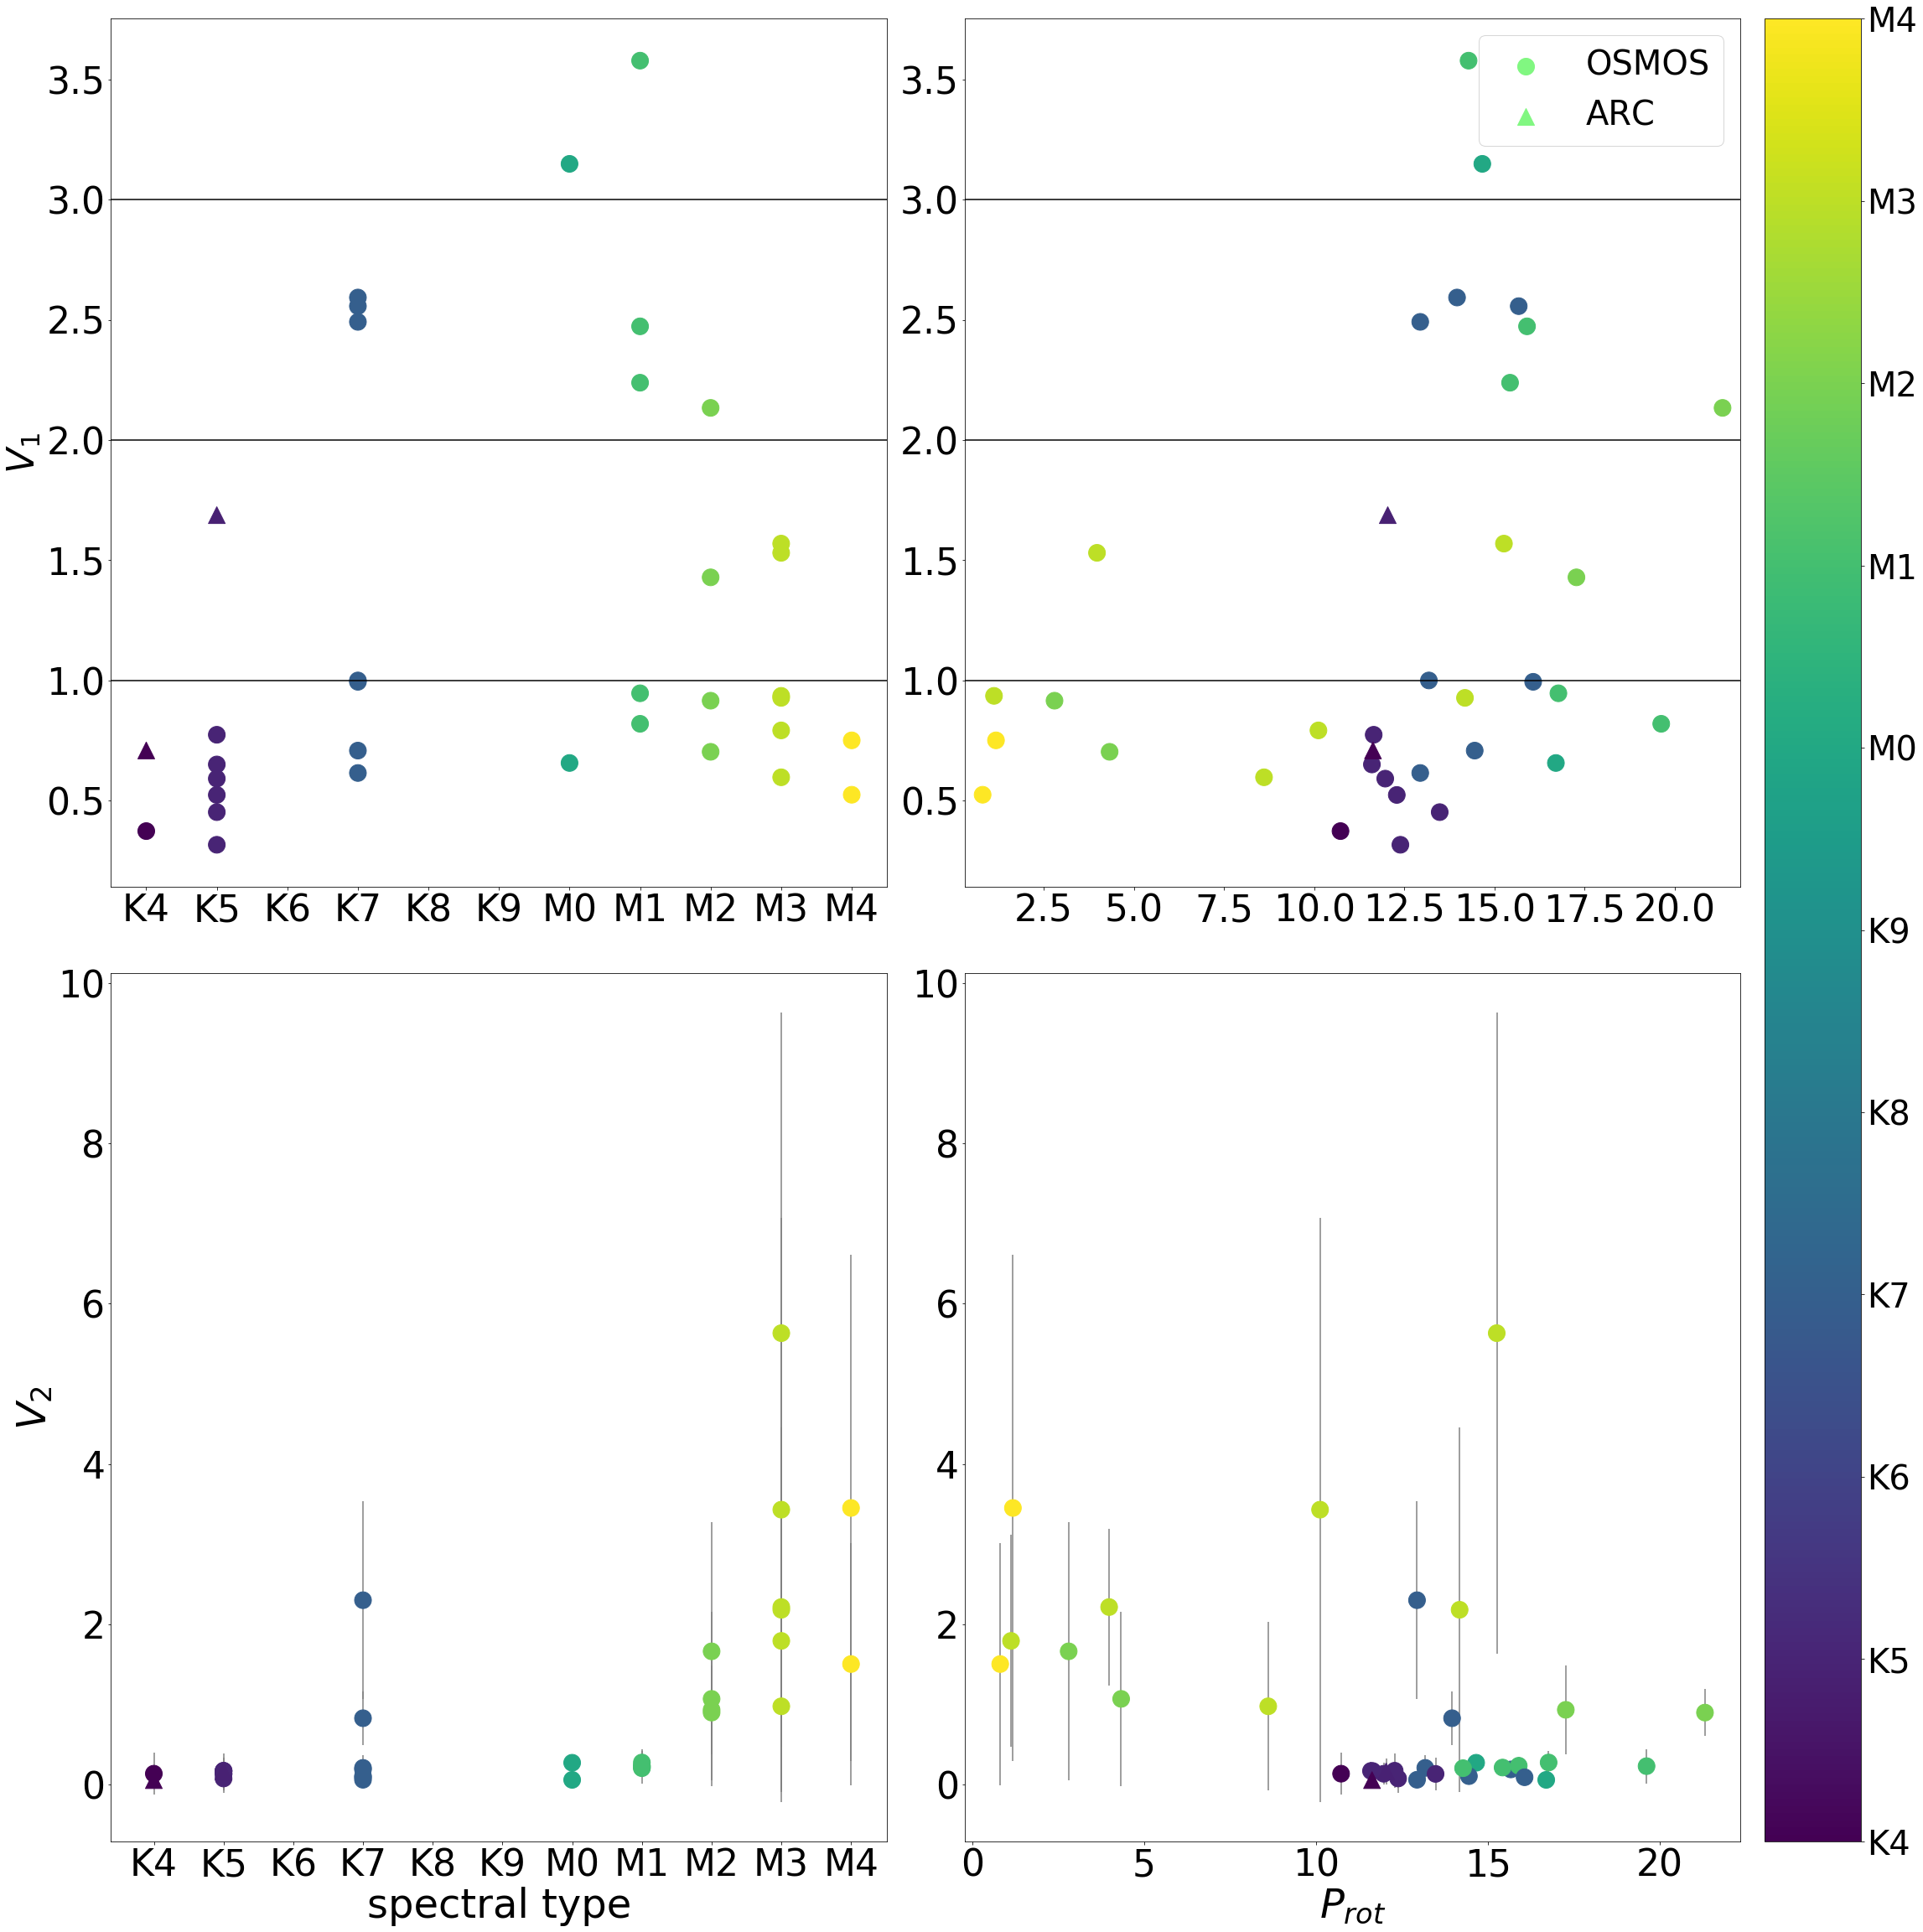

In [33]:
#variability vs. spec.type
corr_info = []
with open('/Users/amandaash/Desktop/Research/analysis/tables/correlation_{0}.csv'.format(today), 'r') as csvFile:
    corr_data = csv.reader(csvFile)
    for row in corr_data:
        corr_info.append(list(row))
csvFile.close()

name_OSMOS = []
m_OSMOS = []
std_OSMOS = []
r_OSMOS = []
mstd_OSMOS = []
spec_OSMOS = []
Prot_OSMOS = []
vary_stat1_OSMOS = []
vary_stat2_OSMOS = []
vary_stat2_err_OSMOS = []
med_EW_OSMOS = []
std_EW_OSMOS = []

name_ARC = []
m_ARC = []
std_ARC = []
r_ARC = []
mstd_ARC = []
spec_ARC = []
Prot_ARC = []
vary_stat1_ARC = []
vary_stat2_ARC = []
vary_stat2_err_ARC = []
med_EW_ARC = []
std_EW_ARC = []

for row in corr_info[1:]:
    name = row[0]
    if name == 'JS482':
        name_ARC.append(name)
        m_ARC.append(float(row[4]))
        r_ARC.append(float(row[5]))
        std_ARC.append(float(row[7]))
        mstd_ARC.append(float(row[8]))
        spec_ARC.append(row[2])
        Prot_ARC.append(float(row[3]))
        vary_stat1_ARC.append(float(row[9]))
        vary_stat2_ARC.append(float(row[10]))
        vary_stat2_err_ARC.append(float(row[11]))
        med_EW_ARC.append(float(row[14]))
        std_EW_ARC.append(float(row[15]))
    elif name == 'JS556':
        name_ARC.append(name)
        m_ARC.append(float(row[4]))
        r_ARC.append(float(row[5]))
        std_ARC.append(float(row[7]))
        mstd_ARC.append(float(row[8]))
        spec_ARC.append(row[2])
        Prot_ARC.append(float(row[3]))
        vary_stat1_ARC.append(float(row[9]))
        vary_stat2_ARC.append(float(row[10]))
        vary_stat2_err_ARC.append(float(row[11]))
        med_EW_ARC.append(float(row[14]))
        std_EW_ARC.append(float(row[15]))
    else:
        name_OSMOS.append(name)
        m_OSMOS.append(float(row[4]))
        r_OSMOS.append(float(row[5]))
        std_OSMOS.append(float(row[7]))
        mstd_OSMOS.append(float(row[8]))
        spec_OSMOS.append(row[2])
        Prot_OSMOS.append(float(row[3]))
        vary_stat1_OSMOS.append(float(row[9]))
        vary_stat2_OSMOS.append(float(row[10]))
        vary_stat2_err_OSMOS.append(float(row[11]))
        med_EW_OSMOS.append(float(row[14]))
        std_EW_OSMOS.append(float(row[15]))

spec_labels = ['K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4']

spec_plot_OSMOS = []

for n in spec_OSMOS:
    if n == 'K4':
        spec_plot_OSMOS.append(1)
    if n == 'K5':
        spec_plot_OSMOS.append(2)
    if n == 'K6':
        spec_plot_OSMOS.append(3)
    if n == 'K7':
        spec_plot_OSMOS.append(4)
    if n == 'K8':
        spec_plot_OSMOS.append(5)
    if n == 'K9':
        spec_plot_OSMOS.append(6)
    if n == 'M0':
        spec_plot_OSMOS.append(7)
    if n == 'M1':
        spec_plot_OSMOS.append(8)
    if n == 'M2':
        spec_plot_OSMOS.append(9)
    if n == 'M3':
        spec_plot_OSMOS.append(10)
    if n == 'M4':
        spec_plot_OSMOS.append(11)
        
spec_plot_ARC = []

for n in spec_ARC:
    if n == 'K4':
        spec_plot_ARC.append(1)
    if n == 'K5':
        spec_plot_ARC.append(2)
    if n == 'K6':
        spec_plot_ARC.append(3)
    if n == 'K7':
        spec_plot_ARC.append(4)
    if n == 'K8':
        spec_plot_ARC.append(5)
    if n == 'K9':
        spec_plot_ARC.append(6)
    if n == 'M0':
        spec_plot_ARC.append(7)
    if n == 'M1':
        spec_plot_ARC.append(8)
    if n == 'M2':
        spec_plot_ARC.append(9)
    if n == 'M3':
        spec_plot_ARC.append(10)
    if n == 'M4':
        spec_plot_ARC.append(11)


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(40,40))
scatter_kwargs = {"zorder":100}
error_kwargs = {"zorder":0}
plt.subplots_adjust()
cmap_ARC = truncate_colormap(plt.get_cmap('viridis'), 0, 0.09090909090909091)
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

sv1 = ax1.scatter(spec_plot_OSMOS, vary_stat1_OSMOS, s = 400, c = spec_plot_OSMOS, cmap='viridis')
ax1.scatter(spec_plot_ARC,vary_stat1_ARC,s = 400, c=spec_plot_ARC,cmap = cmap_ARC,marker='^',label = 'ARC')
ax1.set_xticks(ticks = np.arange(1,12,1))
ax1.set_xticklabels(labels = ('K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4'))
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(44)
ax1.set_ylabel(r'$V_1$', fontsize = 44)
#ax1.set_ylim(0,6)
ax1.hlines([1,2,3], xmin = np.min(spec_plot_OSMOS)-1, xmax=np.max(spec_plot_OSMOS)+1)
ax1.set_xlim(np.min(spec_plot_OSMOS)-0.5, np.max(spec_plot_OSMOS)+0.5)

ax2.scatter(Prot_OSMOS, vary_stat1_OSMOS, s = 400, c = spec_plot_OSMOS, cmap='viridis', label = 'OSMOS')
ax2.scatter(Prot_ARC, vary_stat1_ARC, s = 400, c = spec_plot_ARC, cmap = cmap_ARC,marker='^',label = 'ARC')
#ax2.set_xlabel(r'$P_{rot}$', fontsize = 48)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
#ax2.set_ylim(0,6)
ax2.hlines([1,2,3], xmin = np.min(Prot_OSMOS)-1, xmax=np.max(Prot_OSMOS)+1)
ax2.legend(prop={'size': 40})
ax2.set_xlim(np.min(Prot_OSMOS)-0.5, np.max(Prot_OSMOS)+0.5)

sv2 = ax3.scatter(spec_plot_OSMOS, vary_stat2_OSMOS, s = 400, c = spec_plot_OSMOS, cmap='viridis', **scatter_kwargs, label = 'OSMOS')
ax3.errorbar(spec_plot_OSMOS, vary_stat2_OSMOS, yerr = vary_stat2_err_OSMOS, fmt = 'o', markersize=None, color = 'grey', mew=0, **error_kwargs, label = 'ARC')
ax3.scatter(spec_plot_ARC,vary_stat2_ARC,s = 400, c = spec_plot_ARC, cmap = cmap_ARC, marker = '^', label = 'ARC', **scatter_kwargs)
ax3.errorbar(spec_plot_ARC, vary_stat2_ARC, yerr = vary_stat2_err_ARC,fmt = 'o', markersize=None, color = 'grey', mew = 0, **error_kwargs)
ax3.set_xticks(ticks = np.arange(1,12,1))
ax3.set_xticklabels(labels = ('K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4'))
for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
ax3.set_xlabel(r'spectral type', fontsize = 48)
ax3.set_ylabel(r'$V_2$', fontsize = 48)

ax4.scatter(Prot_OSMOS, vary_stat2_OSMOS, c = spec_plot_OSMOS, s = 400, label = 'OSMOS', **scatter_kwargs)
ax4.errorbar(Prot_OSMOS, vary_stat2_OSMOS, yerr = vary_stat2_err_OSMOS, fmt = 'o',  markersize=None, color = 'grey', mew=0, **error_kwargs)
ax4.scatter(Prot_ARC, vary_stat2_ARC, cmap = cmap_ARC, c = spec_plot_ARC, marker = '^', s = 400, label = 'ARC', **scatter_kwargs)
ax4.errorbar(Prot_ARC, vary_stat2_ARC, yerr = vary_stat2_ARC, fmt = '^', markersize = None, color = 'grey', mew = 0, **error_kwargs)
ax4.set_xlabel(r'$P_{rot}$', fontsize = 48)
for tick in ax4.xaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
for tick in ax4.yaxis.get_major_ticks():
    tick.label.set_fontsize(44) 

cbar_ax = fig.add_axes([0.81, 0.125, 0.04, 0.755])
cbar = plt.colorbar(sv1, ticks = [1,2,3,4,5,6,7,8,9,10,11], cax=cbar_ax)
cbar.ax.set_yticklabels(['K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4'], fontsize = 40)

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.8)

fig.savefig('/Users/amandaash/Desktop/Research/analysis/plots/variance_metrics.pdf')
plt.show()



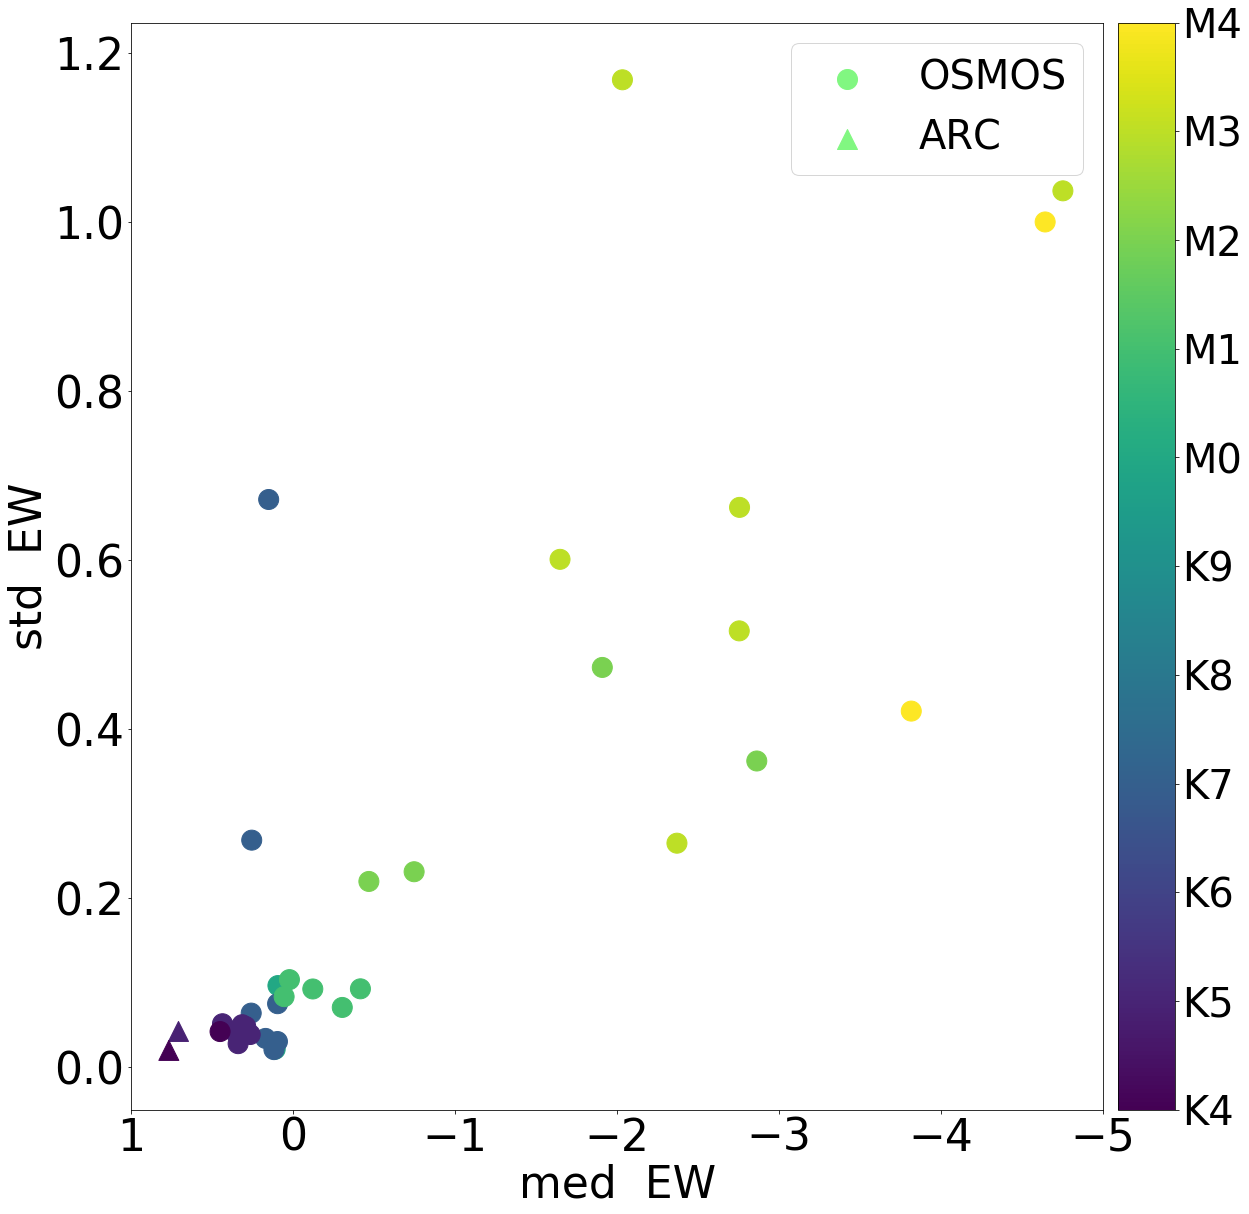

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
plt.subplots_adjust()
ax1 = plt.subplot(111)

sv1 = ax1.scatter(med_EW_OSMOS, std_EW_OSMOS, s = 400, c = spec_plot_OSMOS, cmap='viridis', label = 'OSMOS')
ax1.scatter(med_EW_ARC, std_EW_ARC, s = 400, c = spec_plot_ARC, marker = '^', cmap= cmap_ARC, label = 'ARC')
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
ax1.set_ylabel(r'std  EW', fontsize = 44)
ax1.set_xlabel(r'med  EW', fontsize = 44)
ax1.set_xlim(1,-5)
ax1.legend(prop={'size': 40})

cbar_ax = fig.add_axes([0.81, 0.125, 0.04, 0.755])
cbar = plt.colorbar(sv1, ticks = [1,2,3,4,5,6,7,8,9,10,11], cax=cbar_ax)
cbar.ax.set_yticklabels(['K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4'], fontsize = 40)

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.8)



plt.savefig('/Users/amandaash/Desktop/Research/analysis/plots/std_medEW.pdf', b_box = 'tight')

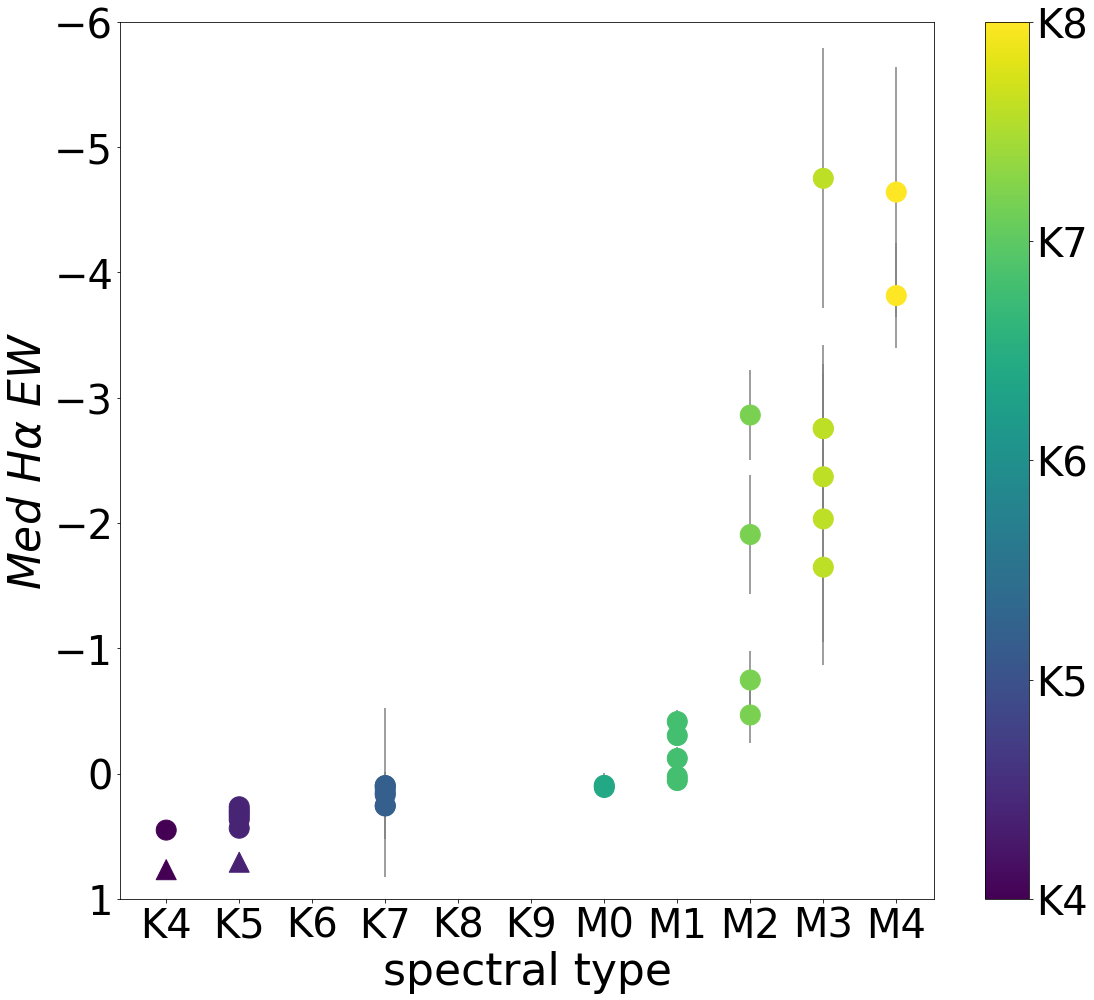

In [47]:
plt.figure(figsize=(16,14))
plt.scatter(spec_plot_OSMOS, med_EW_OSMOS, s = 400, c = spec_plot_OSMOS, label = 'OSMOS', **scatter_kwargs)
plt.errorbar(spec_plot_OSMOS, med_EW_OSMOS, yerr = std_EW_OSMOS, fmt = 'o', markersize=None, color = 'grey', mew=0, **error_kwargs)
plt.scatter(spec_plot_ARC, med_EW_ARC, s = 400, marker = '^', cmap = cmap_ARC, c = spec_plot_ARC, label = 'ARC', **scatter_kwargs)
plt.errorbar(spec_plot_ARC, med_EW_ARC, yerr = std_EW_ARC, fmt = 'o', markersize=None, color = 'grey', mew=0, **error_kwargs)
plt.xlabel(r'spectral type', fontsize = 44)
plt.ylabel(r'$Med \ H \alpha \ EW$', fontsize = 44)
plt.xticks(ticks = np.arange(1,12,1), labels = ('K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4'), fontsize = 40)
plt.yticks(fontsize = 40)
plt.ylim(1,-6)
cbar = plt.colorbar(sv1, ticks = [1,2,3,4,5,6,7,8,9,10,11])
cbar.ax.set_yticklabels(['K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4'], fontsize = 40)
plt.tight_layout()
plt.savefig('/Users/amandaash/Desktop/Research/analysis/plots/activityvspec.pdf')
plt.show()

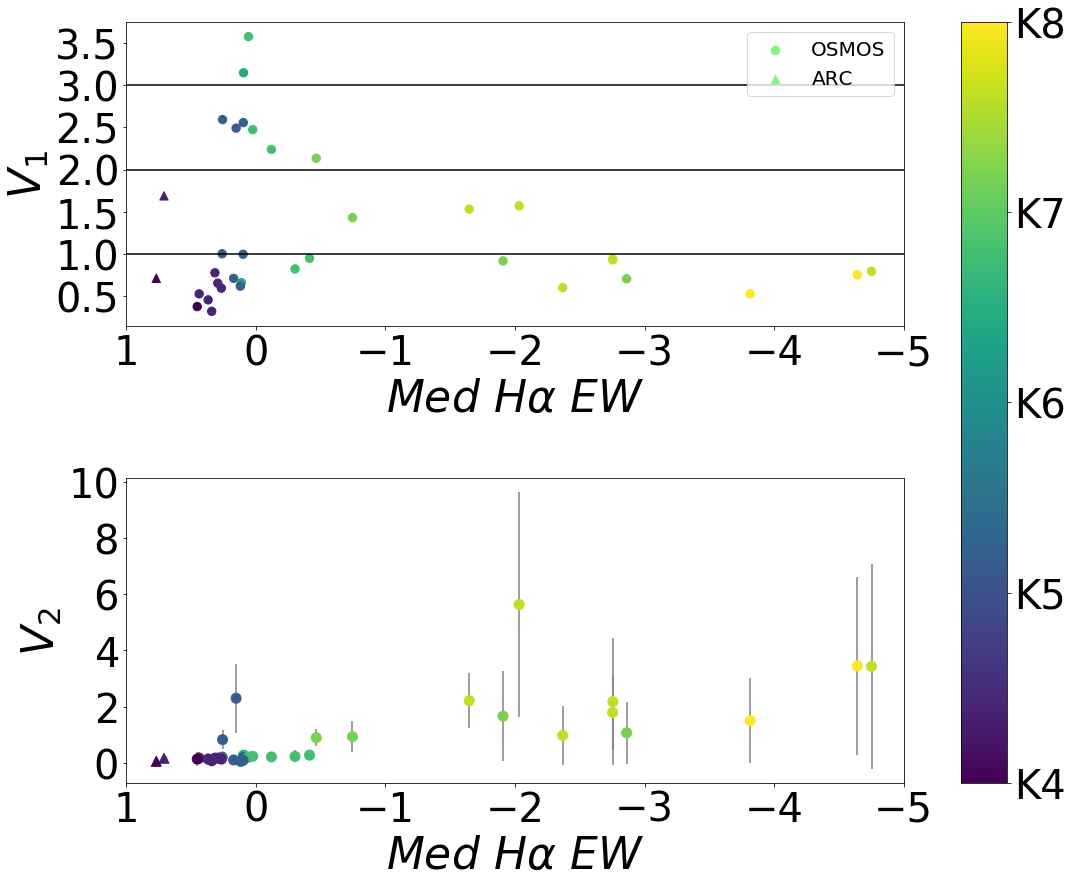

In [48]:
fig, axes = plt.subplots(nrows=2, figsize=(16,14))

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

ax1.scatter(med_EW_OSMOS, vary_stat1_OSMOS, s = 70, c = spec_plot_OSMOS, label = 'OSMOS')
ax1.scatter(med_EW_ARC, vary_stat1_ARC, s = 70, c = spec_plot_ARC, cmap = cmap_ARC, marker = '^', label = 'ARC' )
ax1.set_xlabel(r'$Med \ H \alpha \ EW$', fontsize = 44)
ax1.set_ylabel(r'$V_1$', fontsize = 44)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(40) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(40) 
#ax1.set_ylim(-0.1,6)
ax1.set_xlim(1,-5)
ax1.hlines([1,2,3], xmin = 1, xmax = -6)
ax1.legend(prop={'size': 20})

ax2.scatter(med_EW_OSMOS, vary_stat2_OSMOS, s = 100, c = spec_plot_OSMOS, label = 'OSMOS', **scatter_kwargs)
ax2.errorbar(med_EW_OSMOS, vary_stat2_OSMOS, yerr = vary_stat2_err_OSMOS, fmt = 'o', markersize=None, color='grey', mew=0, **error_kwargs)
ax2.scatter(med_EW_ARC, vary_stat2_ARC, s = 100, c = spec_plot_ARC, cmap = cmap_ARC, marker = '^', label = 'ARC', **scatter_kwargs)
ax2.errorbar(med_EW_ARC, vary_stat2_ARC, yerr = vary_stat2_err_ARC, fmt = 'o', markersize=None, color='grey', mew=0, **error_kwargs)
ax2.set_xlabel(r'$Med \ H \alpha \ EW$', fontsize = 44)
ax2.set_ylabel(r'$V_2$', fontsize = 44)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(40) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(40) 
ax2.set_xlim(1,-5)

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.8)


cbar_ax1 = fig.add_axes([0.85, 0.125, 0.04, 0.755])
cbar = plt.colorbar(sv1, ticks = [1,2,3,4,5,6,7,8,9,10,11], cax=cbar_ax1)
cbar.ax.set_yticklabels(['K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4'], fontsize = 40)

fig.subplots_adjust(wspace=0.1, hspace=0.5, right=0.8)
plt.savefig('/Users/amandaash/Desktop/Research/analysis/plots/varivactivity_OSMOS_ARC.pdf', bbox_inches = 'tight')
plt.show()

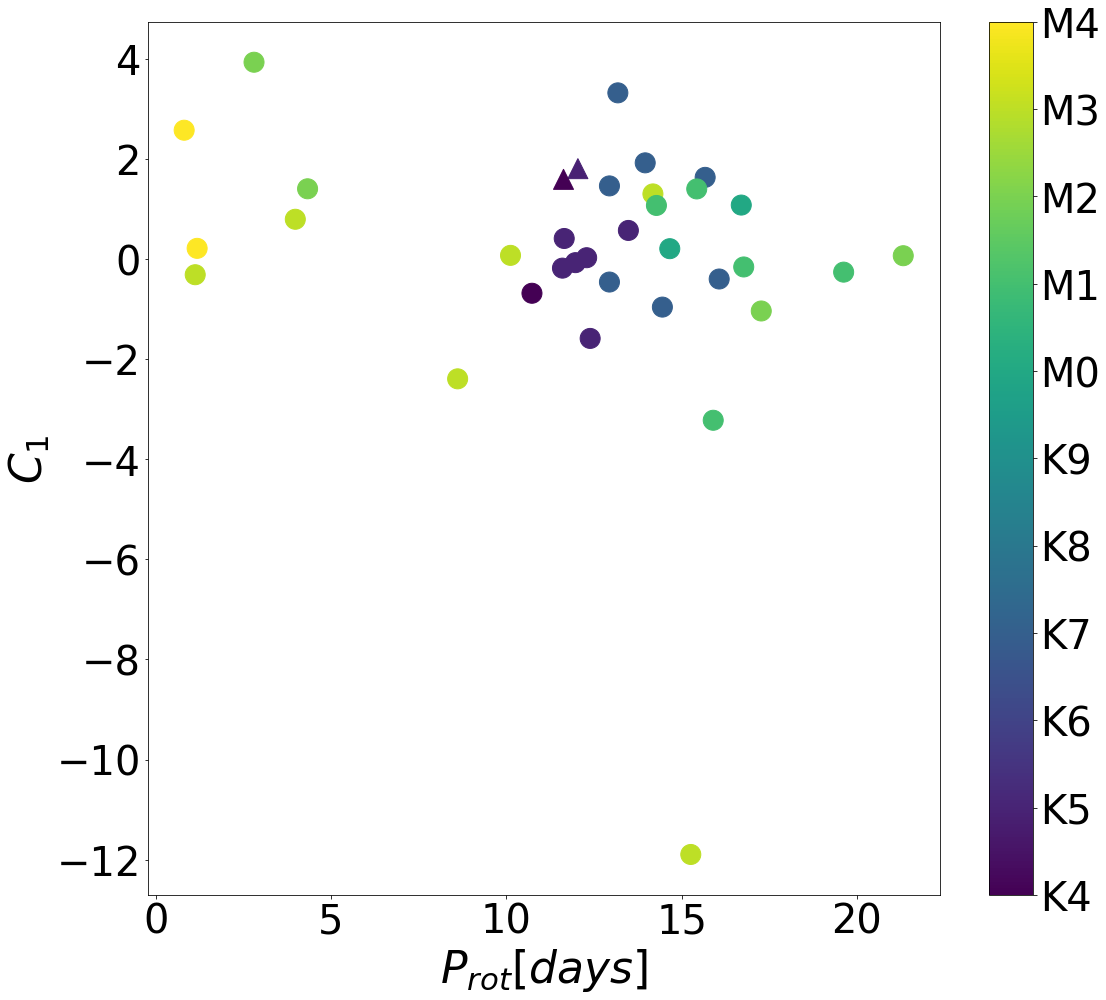

In [37]:
plt.figure(figsize=(16,14))
plt.scatter(Prot_OSMOS, mstd_OSMOS, s = 400, c = spec_plot_OSMOS, label = 'OSMOS')
plt.scatter(Prot_ARC, mstd_ARC, s = 400, marker = '^', cmap = cmap_ARC, c = spec_plot_ARC, label = 'ARC')
plt.xlabel(r'$P_{rot}[days]$', fontsize = 44)
plt.ylabel(r'$C_1$', fontsize = 44)
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40)
#plt.ylim(1,-5)
cbar = plt.colorbar(sv1, ticks = [1,2,3,4,5,6,7,8,9,10,11])
cbar.ax.set_yticklabels(['K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4'], fontsize = 40)
plt.tight_layout()
plt.savefig('/Users/amandaash/Desktop/Research/analysis/plots/rotvsigcorr.pdf')
plt.show()

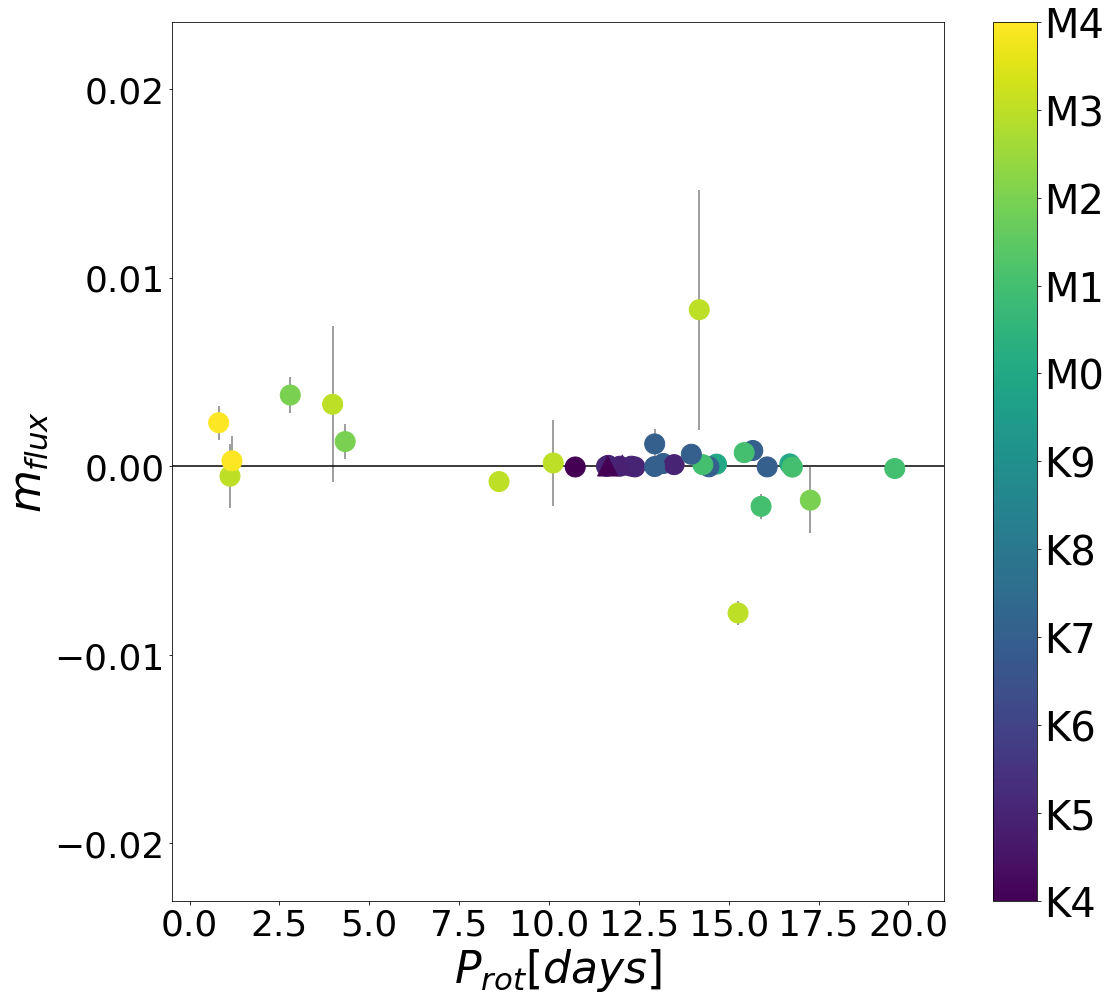

In [38]:
plt.figure(figsize=(16,14))
plt.scatter(Prot_OSMOS, m_OSMOS, s = 400, c = spec_plot_OSMOS, label = 'OSMOS', **scatter_kwargs)
plt.errorbar(Prot_OSMOS, m_OSMOS, yerr = std_OSMOS, fmt = 'o', markersize=None, color='grey', mew=0, **error_kwargs)
plt.scatter(Prot_ARC, m_ARC, s = 400, marker = '^', cmap = cmap_ARC, c = spec_plot_ARC, label = 'ARC', **scatter_kwargs)
plt.errorbar(Prot_ARC, m_ARC, yerr = std_ARC, markersize=None, color='grey', mew=0, **error_kwargs)
plt.xlabel(r'$P_{rot}[days]$', fontsize = 44)
plt.ylabel(r'$m_{flux}$', fontsize = 44)
plt.xticks(fontsize = 36)
plt.yticks(fontsize = 36)
plt.xlim(-0.5,21)
plt.hlines(y = 0, xmin = -1, xmax = 25)
#plt.ylim(1,-5)
cbar = plt.colorbar(sv1, ticks = [1,2,3,4,5,6,7,8,9,10,11])
cbar.ax.set_yticklabels(['K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4'], fontsize = 40)
plt.tight_layout()
plt.savefig('/Users/amandaash/Desktop/Research/analysis/plots/rotvcorr.pdf')
plt.show()

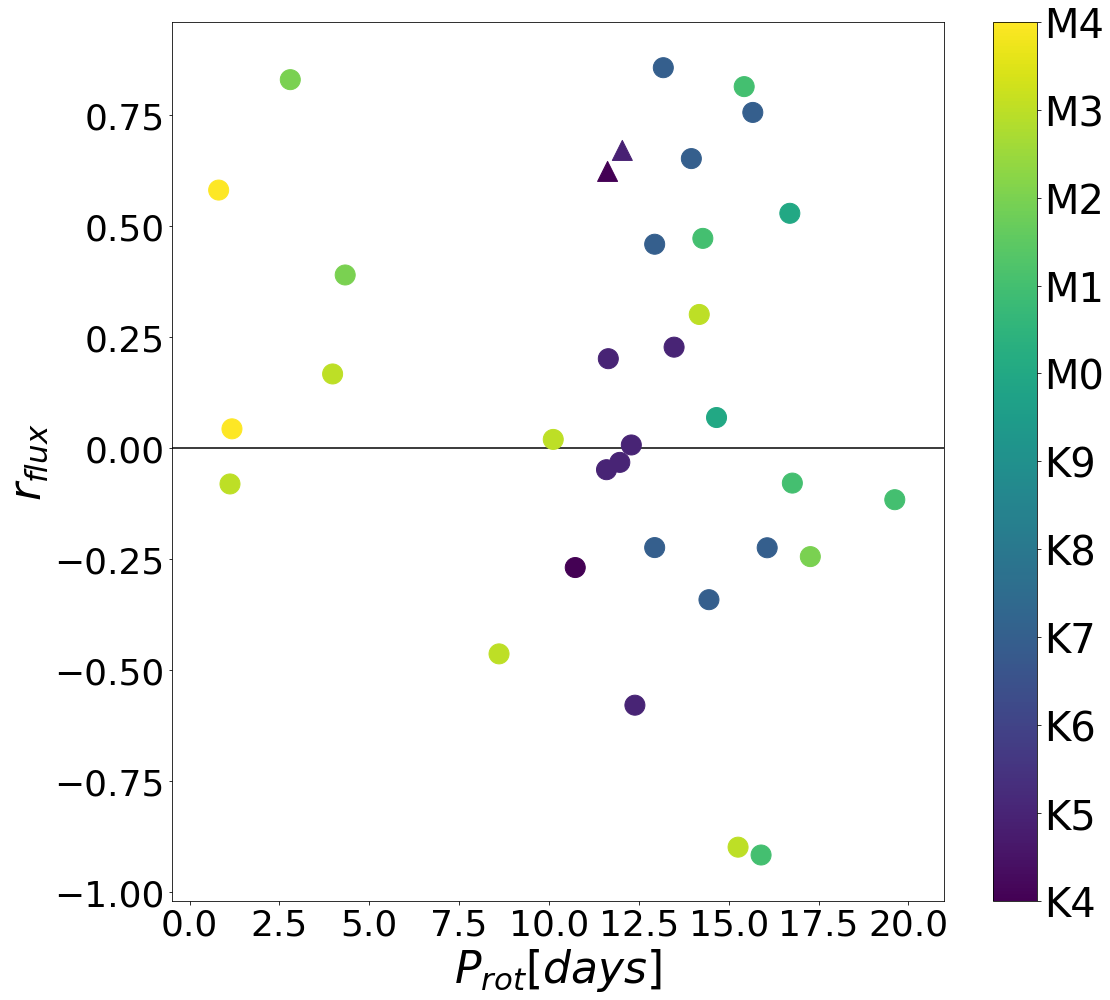

In [39]:
plt.figure(figsize=(16,14))
plt.scatter(Prot_OSMOS, r_OSMOS, s = 400, c = spec_plot_OSMOS, label = 'OSMOS', **scatter_kwargs)
#plt.errorbar(Prot_OSMOS, r_OSMOS, yerr = std_OSMOS, fmt = 'o', markersize=None, color='grey', mew=0, **error_kwargs)
plt.scatter(Prot_ARC, r_ARC, s = 400, marker = '^', cmap = cmap_ARC, c = spec_plot_ARC, label = 'ARC', **scatter_kwargs)
#plt.errorbar(Prot_ARC, r_ARC, yerr = std_ARC, markersize=None, color='grey', mew=0, **error_kwargs)
plt.xlabel(r'$P_{rot}[days]$', fontsize = 44)
plt.ylabel(r'$r_{flux}$', fontsize = 44)
plt.xticks(fontsize = 36)
plt.yticks(fontsize = 36)
plt.xlim(-0.5,21)
plt.hlines(y = 0, xmin = -1, xmax = 25)
#plt.ylim(1,-5)
cbar = plt.colorbar(sv1, ticks = [1,2,3,4,5,6,7,8,9,10,11])
cbar.ax.set_yticklabels(['K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4'], fontsize = 40)
plt.tight_layout()
plt.savefig('/Users/amandaash/Desktop/Research/analysis/plots/rotvr.pdf')
plt.show()

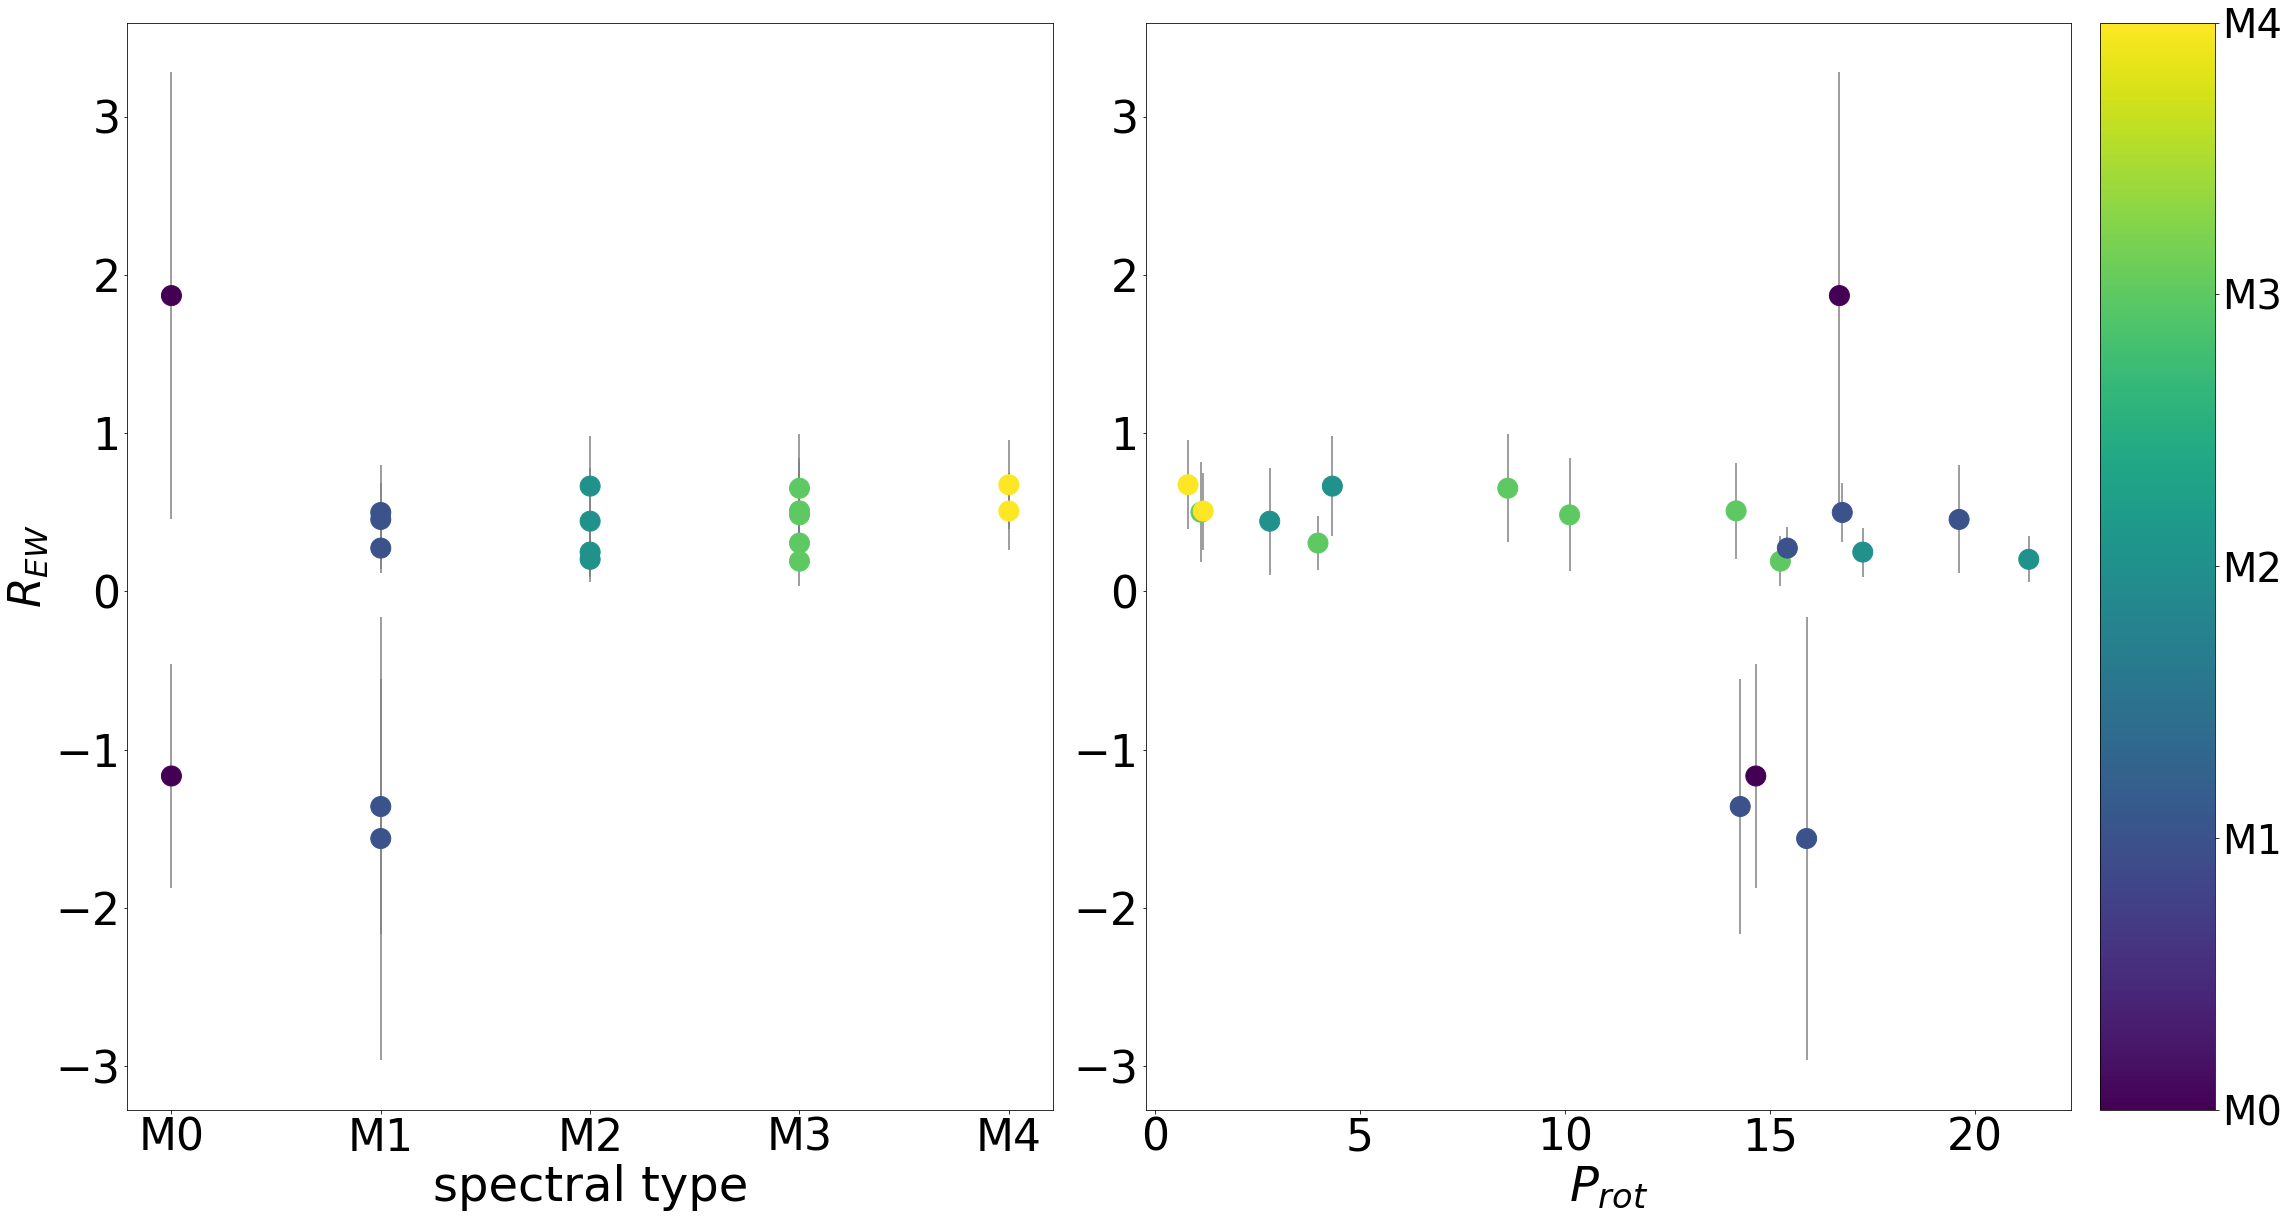

In [40]:
#R_EW metric for Mdwarfs 
corr_info = []
with open('/Users/amandaash/Desktop/Research/analysis/tables/correlation_{0}.csv'.format(today), 'r') as csvFile:
    corr_data = csv.reader(csvFile)
    for row in corr_data:
        corr_info.append(list(row))
csvFile.close()

spec = []
Prot = []
R_EW = []
R_EW_sigma = []


for row in corr_info[1:]:
    if row[2][0] == 'M':
        spec.append(row[2])
        Prot.append(float(row[3]))
        R_EW.append(float(row[12]))
        R_EW_sigma.append(float(row[13]))
    

spec_labels = ['M0', 'M1', 'M2', 'M3', 'M4']

spec_plot = []

for n in spec:
    if n == 'M0':
        spec_plot.append(1)
    if n == 'M1':
        spec_plot.append(2)
    if n == 'M2':
        spec_plot.append(3)
    if n == 'M3':
        spec_plot.append(4)
    if n == 'M4':
        spec_plot.append(5)


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(40,20))
scatter_kwargs = {"zorder":100}
error_kwargs = {"zorder":0}
plt.subplots_adjust()
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)


sv1 = ax1.scatter(spec_plot, R_EW, s = 400, c = spec_plot, cmap='viridis', **scatter_kwargs)
ax1.errorbar(spec_plot, R_EW, yerr = R_EW_sigma, fmt = 'o', markersize=None, color='grey', mew=0, **error_kwargs)
ax1.set_xticks(ticks = np.arange(1,6,1))
ax1.set_xticklabels(labels = ('M0', 'M1', 'M2', 'M3', 'M4'))
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
ax1.set_xlabel(r'spectral type', fontsize = 48)
ax1.set_ylabel(r'$R_{EW}$', fontsize = 44)



ax2.scatter(Prot, R_EW, s = 400, c = spec_plot, cmap='viridis', **scatter_kwargs)
ax2.errorbar(Prot,R_EW, yerr = R_EW_sigma, fmt = 'o', markersize=None, color='grey', mew=0, **error_kwargs)
ax2.set_xlabel(r'$P_{rot}$', fontsize = 48)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(44) 

cbar_ax = fig.add_axes([0.81, 0.125, 0.04, 0.755])
cbar = plt.colorbar(sv1, ticks = [1,2,3,4,5], cax=cbar_ax)
cbar.ax.set_yticklabels(['M0', 'M1', 'M2', 'M3', 'M4'], fontsize = 40)

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.8)

fig.savefig('/Users/amandaash/Desktop/Research/analysis/plots/R_EW_Mdwarf.pdf', bbox_inches = 'tight')
plt.show()


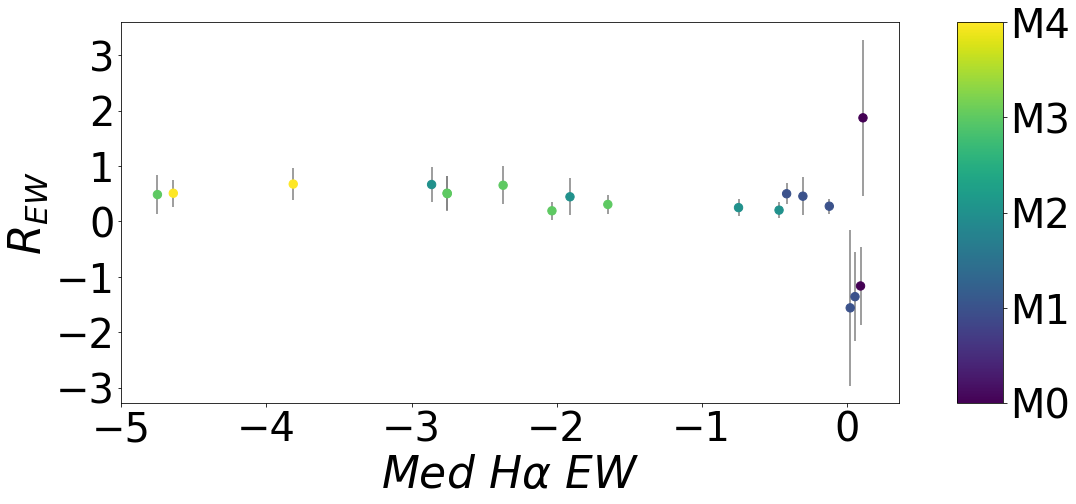

In [41]:
corr_info = []
with open('/Users/amandaash/Desktop/Research/analysis/tables/correlation_{0}.csv'.format(today), 'r') as csvFile:
    corr_data = csv.reader(csvFile)
    for row in corr_data:
        corr_info.append(list(row))
csvFile.close()

med_EW = []
R_EW = []
R_EW_sigma = []


for row in corr_info[1:]:
    if row[2][0] == 'M':
        R_EW.append(float(row[12]))
        R_EW_sigma.append(float(row[13]))
        med_EW.append(float(row[14]))
        
spec_plot = []

for n in spec:
    if n == 'M0':
        spec_plot.append(1)
    if n == 'M1':
        spec_plot.append(2)
    if n == 'M2':
        spec_plot.append(3)
    if n == 'M3':
        spec_plot.append(4)
    if n == 'M4':
        spec_plot.append(5)

fig, axes = plt.subplots(nrows=1, figsize=(16,7))

ax1 = plt.subplot(111)
ax1.scatter(med_EW, R_EW, s = 70, c = spec_plot, **scatter_kwargs)
ax1.errorbar(med_EW, R_EW, yerr = R_EW_sigma, fmt = 'o', markersize=None, color='grey', mew=0, **error_kwargs)
ax1.set_xlabel(r'$Med \ H \alpha \ EW$', fontsize = 44)
ax1.set_ylabel(r'$R_{EW}$', fontsize = 44)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(40) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(40) 

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.8)


cbar_ax1 = fig.add_axes([0.85, 0.125, 0.04, 0.755])
cbar = plt.colorbar(sv1, ticks = [1,2,3,4,5], cax=cbar_ax1)
cbar.ax.set_yticklabels(['M0', 'M1', 'M2', 'M3', 'M4'], fontsize = 40)

fig.subplots_adjust(wspace=0.1, hspace=0.5, right=0.8)


plt.savefig('/Users/amandaash/Desktop/Research/analysis/plots/varivactivity_Rew_mdwarf.pdf', bbox_inches = 'tight')
plt.show()